`LangChain`发展至现在，仍然是构建大语言模型应用程序的前沿框架之一。在`1.0`版本之前，已经基本完成了由传统类到表达式语言(LCEL)的重要过渡，给开发者带来的直接利好就是**定义和执行分步操作序列（也称为链）会更加简单**。用更专业的术语来说，**使用`LangChain` 构建的是 DAG（有向无环图）**。而之所以会出现`LangGraph`框架，根本原因是在于随着AI应用（特别是AI Agent）的发展，**对于大语言模型的使用不仅仅是作为执行工具，而更多作为推理引擎的需求在日益增长**。这种转变带来的是更多的重复（循环）和复杂条件的交互需求，这就导致**基于`LCEL`的线性序列构建方式在构建更复杂、更智能的系统时显示出了明显的局限性。**

而`LangGraph`就是为了解决这种复杂场景而诞生的。顾名思义，`LangGraph` 在图这个概念上有很大的侧重，**它的出现就是`要解决线性序列的局限性问题，而解决的方法就是循环图`。**在`LangGraph`框架中，**用图取代了`LangChain`的`AgentExecutor`（代理执行器），用来管理代理的生命周期并在其状态内将暂存器作为消息进行跟踪，增加了以循环方式跨各种计算步骤协调多个链或参与者的功能**。这就与 `LangChain` 将代理视为可以附加工具和插入某些提示的对象不同，对于图来说，意味着**我们可以从任何可运行的功能或代理或链作为一个程序的起点。**

👇是一个LangGraph实现ReAct的简单示例。LangGraph的底层图算法采用消息，也就是我们之前讲到的`State`传递机制来定义通用程序。当一个节点`Node`完成操作后，它会通过一条`Edge`或多条边向其他节点发送消息。这些接收节点随后执行其函数，将生成的消息传递给下一组节点，流程以此类推。这个设计灵感来自谷歌的[Pregel](https://research.google/pubs/pregel-a-system-for-large-scale-graph-processing/)系统，整体以离散的超级步（super-step）推进。

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/101104.png" width=80%></div>

一个超级步可视为对图中节点的一次迭代。并行运行的节点属于同一个超级步，而顺序运行的节点则分属不同的超级步。图执行开始时，所有节点均处于未激活（inactive）状态。当节点在其任意入边（或 “通道”）上接收到新消息（状态）时，会变为激活（active）状态。激活的节点随后执行其函数，并返回更新结果。在每个超级步结束时，没有入边消息的节点会通过将自身标记为未激活来发起暂停（halt）投票。当所有节点均处于未激活状态且无消息在传输时，图执行终止。

官方自己总结的`LangGraph`的优势则是：

- **循环和分支**：在应用程序中实现循环和条件。
- **持久性**：在图中的每个步骤之后自动保存状态。随时暂停和恢复图形执行，以支持错误恢复、人机交互工作流程、时间旅行等。
- **人机交互**：中断图形执行以批准或编辑代理计划的下一个操作。
- **流支持**：流输出由每个节点生成（包括令牌流）。

# StateGraph

**定义图时要做的第一件事是定义图的`State`**。状态表示会随着图计算的进行而维护和更新的上下文或记忆。它用来确保图中的每个步骤都可以访问先前步骤的相关信息，从而可以根据整个过程中积累的数据进行动态决策。这个过程通过状态图`StateGraph`类实现，在当前版本的LangGraph，StateGraph已经不需要再继承自Graph类，StateGraph专注于状态管理和节点编排，而执行逻辑由Pregel处理，这是一个重要的架构变化，让代码结构更加清晰。

In [ ]:
from langgraph.graph import StateGraph

class StateGraph(Generic[StateT, ContextT, InputT, OutputT]):
    """
        一种节点通过读写共享状态进行通信的图（StateGraph）。

        警告:
            StateGraph 是一个构建器类，不能直接用于执行。你必须先调用 `.compile()` 方法，
            创建一个支持 `invoke()`、`stream()`、`astream()` 和 `ainvoke()` 等方法的可执行图。
            更多细节请参见 CompiledStateGraph 的文档说明。

        Args:
            state_schema (type[StateT]): 定义状态的模式类，必填参数
            context_schema (type[ContextT] | None, optional): 定义运行时上下文的模式类。
                用于向节点暴露不可变的上下文数据，例如用户标识（user_id）、数据库连接（db_conn）等。
                默认值为 None。
            input_schema (type[InputT] | None, optional): 定义图输入的模式类。
                默认值为 None。
            output_schema (type[OutputT] | None, optional): 定义图输出的模式类。
                默认值为 None。
    """
    pass

In [54]:
from langgraph.graph import StateGraph, MessagesState
from dataclasses import dataclass

# ==========================================
# 定义状态
# ==========================================
# 这里我们使用 LangGraph 内置的 MessagesState 来管理对话
# 并扩展一个字段来管理运行时生成的问候语
class OverallState(MessagesState):
    runtime_greeting: str

@dataclass
class Context:
    user_name: str

# ==========================================
# 利用State构建图 (Builder)
# ==========================================
# 初始化构建器，指定状态结构
builder = StateGraph(state_schema=OverallState, context_schema=Context)

## compile方法

定义好StateGraph的实例后，还需要调用`compile`方法编译图，生成可执行的图实例，它会对图的结构执行一些基本检查（例如确保没有孤立节点等）。此外，你还可以在此指定运行时参数，如检查点和断点等等。

In [ ]:
def compile(
    checkpointer: Checkpointer = None,
    *,
    cache: BaseCache | None = None,
    store: BaseStore | None = None,
    interrupt_before: All | list[str] | None = None,
    interrupt_after: All | list[str] | None = None,
    debug: bool = False,
    name: str | None = None,
) -> CompiledStateGraph[StateT, ContextT, InputT, OutputT]:
    """
    将 StateGraph（状态图）编译为 CompiledStateGraph（已编译状态图）对象。

    编译后的图实现了 Runnable 接口，支持调用、流式传输、批量处理和异步运行。

    Args:
        checkpointer (Checkpointer, optional): 检查点保存器对象或标志位。
            若提供该参数，此 Checkpointer（检查点工具）将作为图的完整版本化"短期记忆"，
            支持从任意节点暂停、恢复和重放图的执行。
            若为 None，当该图作为子图使用时，可能会继承父图的检查点工具。
            若为 False，将不使用也不继承任何检查点工具。
            默认值为 None。
        cache (BaseCache | None, optional): 缓存对象。默认值为 None。
        store (BaseStore | None, optional): 存储对象。默认值为 None。
        interrupt_before (All | list[str] | None, optional): 可选的节点名称列表，
            指定在哪些节点执行前触发中断。默认值为 None。
        interrupt_after (All | list[str] | None, optional): 可选的节点名称列表，
            指定在哪些节点执行后触发中断。默认值为 None。
        debug (bool, optional): 用于指示是否启用调试模式的标志位。默认值为 False。
        name (str | None, optional): 已编译图的名称。默认值为 None。

    Returns:
        CompiledStateGraph[StateT, ContextT, InputT, OutputT]: 已编译完成的 StateGraph（状态图）。
    """
    pass

# Node

在 LangGraph 中，节点本质上是 Python 函数（可以是同步或异步的），它们接受以下参数：
- state – 图的状态
- config – 一个 RunnableConfig 对象，包含配置信息（如 thread_id）以及追踪信息（如标签 tags），Part 01 Lesson 02里面讲过
- runtime – 一个 Runtime 对象，包含运行时上下文以及其他信息（如 store 和 stream_writer），但不包含state

Runtime对象的属性：

| 属性 | 类型 | 说明 |
|------|------|------|
| context | ContextT | 静态上下文，如 user_id、db_conn 等运行依赖，可视为"运行时的依赖注入" |
| store | BaseStore \| None | 存储接口，用于持久化数据和记忆功能 |
| stream_writer | StreamWriter | 流写入函数，用于向自定义流输出数据 |
| previous | Any | 功能 API 中上一次调用的返回值（仅在提供 checkpointer 时可用） |

## 定义节点逻辑

In [61]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.runnables import RunnableConfig
from langgraph.runtime import Runtime
from langchain_qwq import ChatQwen
from langchain_deepseek import ChatDeepSeek

import datetime
import os

# ==========================================
# 定义节点逻辑
# ==========================================
def context_initialize(state: OverallState, runtime: Runtime[Context]):
    """
    初始化节点：利用 Runtime 信息（如当前时间）生成个性化问候
    注意：这里接收了第二个参数 config，可以从里面获取 runtime 信息
    """
    # Runtime 逻辑：根据当前时间决定问候语
    current_hour = datetime.datetime.now().hour
    if current_hour < 12:
        time_greeting = "早上"
    elif current_hour < 18:
        time_greeting = "下午"
    else:
        time_greeting = "晚上"
    
    # 也可以从 config 中读取用户传入的 runtime 参数
    user_name = runtime.context.user_name
    
    greeting_msg = f"{user_name}，{time_greeting}好！"

    runtime_msg = f"现在是{time_greeting}，如有必要，在回答时请参考这个上下文。"
    
    # 返回初始化的状态
    return {
        "runtime_greeting": greeting_msg,
        # 追加运行时上下文到 messages 列表
        "messages": [SystemMessage(content=runtime_msg)]
    }


def answer_with_llm(state: OverallState, config: RunnableConfig):
    """
    回答用户的输入，利用 Config 中注入的 LLM 参数来调用不同的模型（如 Qwen 或 DeepSeek）
    """
    # 1. 从 Config 中获取 LLM 实例
    # 这允许我们在编译时决定用哪个模型，或者在调用时临时覆盖
    llm = config.get("configurable", {}).get("llm") 
    
    if llm.lower()=="deepseek":
        model = ChatDeepSeek(model="deepseek-chat", temperature=0.7)
    else:
        # 如果没有从外部传入，则使用默认（或者报错）
        model = ChatQwen(
            model="qwen-plus",
            api_key=os.getenv("DASHSCOPE_API_KEY"),
            base_url=os.getenv("DASHSCOPE_BASE_URL"),
            temperature=0.7,
        )
    
    for msg in state["messages"]:
        if isinstance(msg, HumanMessage):
            human_msg = msg.content
    # 2. 构造提示词，结合之前的 Runtime 问候语
    prompt = f"""
    回答用户的提问: {human_msg}。
    在此之前，请先跟用户打招呼。打招呼内容为：{state['runtime_greeting']}。
    """
    response = model.invoke(prompt)
    return {
        # response 是 AIMessage 类型，包含了模型的回复内容
        "messages": [response]
    }

## 添加节点到图中

在编写好节点函数之后，我们需要手动把节点添加到图中，利用add_node方法可以很快实现这个需求，该方法具有以下参数：
| 参数 | 类型 | 说明 |
|------|------|------|
| node | str \| StateNode | 节点名称（字符串）或节点函数/可运行对象。如果是字符串，则需要配合 action 参数使用 |
| action | StateNode \| None | 节点执行的动作（函数或可运行对象）。当 node 为字符串时使用 |
| defer | bool | 是否延迟执行节点直到运行即将结束。默认为 False |
| metadata | dict[str, Any] \| None | 与节点关联的元数据 |
| input_schema | type \| None | 节点的输入模式。默认为图的 state_schema |
| retry_policy | RetryPolicy \| Sequence[RetryPolicy] \| None | 节点的重试策略。如果提供序列，将应用第一个匹配的策略 |
| cache_policy | CachePolicy \| None | 节点的缓存策略 |
| destinations | dict[str, str] \| tuple[str, ...] \| None | 指示节点可以路由到的目标。用于无边图，仅用于图渲染，不影响执行 |

In [57]:
# 添加节点
builder.add_node("initialize", context_initialize)
builder.add_node("generate", answer_with_llm)

至此，我们已经成功添加了两个节点到StateGraph的示例builder中。

### Node Caching

LangGraph 支持基于节点输入对任务/节点进行缓存。要使用缓存功能，需要设定以下参数：
- 在编译图（或指定入口点）时指定一个缓存；
- 为节点指定缓存策略。每种缓存策略均支持以下配置项：
  - key_func：用于根据节点的输入生成缓存键，默认使用 pickle 对输入进行哈希；
  - ttl：缓存的生存时间（以秒为单位）。若未指定，缓存将永不过期。

In [20]:
import time
from langgraph.graph import StateGraph, START
from langgraph.cache.memory import InMemoryCache
from langgraph.types import CachePolicy
from typing import TypedDict

class State(TypedDict):
    city: str
    weather: str = ""


# 模拟耗时的天气查询函数
def fetch_weather(state):
    city = state["city"]
    print(f"正在查询 {city} 的天气...（模拟耗时）")
    time.sleep(2)  # 模拟网络延迟
    return {"weather": f"{city} 晴朗，25°C"}

# 构建图，使用简易的schema
builder = StateGraph(state_schema=State)

# 添加节点，并指定缓存策略
builder.add_node(
    "get_weather",
    fetch_weather,
    cache_policy=CachePolicy(
        ttl=60,  # 缓存 60 秒
        # key_func 默认为 hash(pickle(input))，这里也可自定义：
        # key_func=lambda input: input["city"]
    )
)
builder.set_entry_point("get_weather")
builder.set_finish_point("get_weather")

# 编译图时指定缓存（例如使用内存缓存）
memory = InMemoryCache() 

graph = builder.compile(cache=memory)

# 第一次调用
result1 = graph.invoke({"city": "北京"})
print(result1)  # 输出：正在查询北京的天气... → 北京 晴朗，25°C

# 立即再次调用（在 TTL 内）
result2 = graph.invoke({"city": "北京"})
print(result2)  # 不会打印“正在查询...”，直接返回缓存结果

正在查询 北京 的天气...（模拟耗时）
{'city': '北京', 'weather': '北京 晴朗，25°C'}
{'city': '北京', 'weather': '北京 晴朗，25°C'}


### 重试策略

在许多使用场景中，你可能希望节点拥有自定义的重试策略，例如当你调用 API、查询数据库或调用大语言模型（LLM）时。LangGraph 允许你为节点添加重试策略。

要配置重试策略，请向 add_node 方法传入 retry_policy 参数。该参数接收一个 RetryPolicy 命名元组对象，该对象支持以下参数：

| 参数 | 类型 | 默认值 | 说明 |
|------|------|--------|------|
| initial_interval | float | 0.5 | 首次重试前的等待时间（秒）|
| backoff_factor | float | 2.0 | 每次重试后间隔时间的乘数 |
| max_interval | float | 128.0 | 重试间隔的最大时间（秒）|
| max_attempts | int | 3 | 最大尝试次数（包含第一次）|
| jitter | bool | True | 是否在重试间隔中添加随机抖动 |
| retry_on | Exception/Sequence/Callable | default_retry_on | 触发重试的异常类型或判断函数 |

> 在LangChain 1.0以上版本中，重试策略通过中间件来完成

In [115]:
from sqlite3 import connect
from langgraph.graph import StateGraph, START, END
from langgraph.types import RetryPolicy
from langchain_core.runnables import RunnableConfig
import random
from typing import TypedDict, Annotated

from pydantic.type_adapter import R

# ==========================================
# 1. 定义状态
# ==========================================
class AgentState(TypedDict):
    location: str
    weather: str
    retry_count: int

# ==========================================
# 2. 模拟一个“不靠谱”的工具 (节点)
# ==========================================
def unreliable_weather_tool(state: AgentState, config: RunnableConfig):
    """
    模拟一个不稳定的天气 API
    80% 的概率抛出异常，20% 的概率成功返回数据
    """
    # 模拟随机网络延迟或故障
    if random.random() < 0.6: # 60% 的概率失败
        print(f"⛈️  连接天气服务器超时... (正在尝试获取 {state['location']} 的天气)")
        config["configurable"]["retry_count"] += 1
        # state["retry_count"] = config["configurable"]["retry_count"]是不会生效的
        # 此时只会修改本地副本，必须returen才会提交
        raise ConnectionError("Network timeout")
    else:
        print(f"✅ 成功！获取到 {state['location']} 的天气数据。")
        return {"weather": f"{state['location']} 的天气是晴朗的，25度。", "retry_count": config["configurable"]["retry_count"]}


# ==========================================
# 3. 构建图并添加节点
# ==========================================
builder = StateGraph(AgentState)

# max_attempts=5 表示最多重试 5 次，超过次数抛出ConnectionError: Network timeout
builder.add_node("get_weather", unreliable_weather_tool,retry_policy=RetryPolicy(max_attempts=10, retry_on=ConnectionError, initial_interval=0.1))
builder.add_edge(START, "get_weather")
builder.add_edge("get_weather", END)

graph = builder.compile()

# ==========================================
# 4. 运行测试
# ==========================================

result = graph.invoke(
    {"location": "宁波"},
    config={
        "configurable": {
            "retry_count": 0
        }
    }
    )

print(f"\n最终结果: {result['weather']}")
print(f"\n重试次数: {result['retry_count']}")

✅ 成功！获取到 宁波 的天气数据。

最终结果: 宁波 的天气是晴朗的，25度。

重试次数: 0


# Edge

边（Edges）定义了逻辑的路由方式，以及图如何决定何时停止执行，是图运作机制的重要组成部分，也是不同节点之间相互通信的关键方式。边主要有以下几种类型：
- 普通边（Normal Edges）：直接从一个节点跳转到下一个节点。
- 条件边（Conditional Edges）：调用一个函数，根据其返回结果决定下一步应跳转到哪个（或哪些）节点。
- 入口点（Entry Point）：当用户输入到达时，指定首先调用哪个节点。
- 条件入口点（Conditional Entry Point）：当用户输入到达时，调用一个函数来动态决定首先调用哪个（或哪些）节点。

一个节点可以拥有多个出边（outgoing edges）。如果某个节点具有多条出边，那么所有目标节点将在下一个“超步”（superstep）中并行执行。
作为入门，这一小节我们只介绍普通边。

In [58]:
from langgraph.graph import START, END

builder.add_edge(START,"initialize")
builder.add_edge("initialize","generate")
builder.add_edge("generate", END)

# 节点和边都准备就绪后，可以编译图了
graph = builder.compile()

# 图可视化

在 Jupyter Notebook 或 IPython 环境中，可以直接把 LangGraph 图可视化出来，直接以图片的形式展示。

draw_mermaid_png() 默认使用 Mermaid.INK API （ https://mermaid.ink ）来渲染图片，所以有可能遇到SSL错误等网络，多试几次就好。

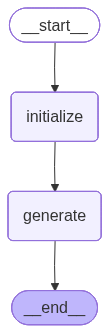

In [39]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# 运行图

跟模型一样，通过调用invoke、stream等方法即可运行编译好的graph。

除了State之外，在运行时通过传参可以动态改变运行配置，常见的有context和config。config参数在Part 01模型使用时讲过，这里不再赘述。context参数则是在运行时动态传递的上下文信息，例如用户姓名、用户ID等。在图中可以通过runtime.context来访问，使用context需遵循以下步骤：
1. 指定上下文的schema
2. 将runtime参数加入节点函数或者条件边函数的参数中：runtime: Runtime[YourContextSchema]
3. 将上下文传入图中：在调用时将上下文实例传递给图。

In [ ]:
# 调用时，通过 configurable 传入 config，通过context传递上下文
result = graph.invoke(
    {"messages": [HumanMessage(content="你好，介绍一下你自己")]},
    context={
        "user_name": "Pet"
    },
    config={
        "configurable": {
            "llm": "deepseek", # 选择模型
        }
    }
)
for msg in result['messages']:
    msg.pretty_print()

# 完整示例参考

In [60]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

# ==========================================
# 第一步：定义状态 (Schema)
# ==========================================
class InputState(TypedDict):
    name: str

class OutputState(TypedDict):
    final_intro: str

# OverallState 包含了所有中间和最终需要的字段
class OverallState(TypedDict):
    name: str
    greeting: str # 中间状态
    final_intro: str # 最终状态

# ==========================================
# 第二步：定义节点逻辑 (Nodes)
# ==========================================
def node_add_greeting(state):
    # 节点1：添加问候语前缀
    return {"greeting": f"Hello, my name is {state['name']}"}

def node_finalize(state):
    # 节点2：完善句子
    return {"final_intro": f"{state['greeting']}. Nice to meet you!"}

# ==========================================
# 第三步：构建图 (Builder)
# ==========================================
# 初始化构建器，指定状态结构
builder = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)

# 添加节点
builder.add_node("add_greeting", node_add_greeting)
builder.add_node("finalize", node_finalize)

# 添加边 (Edge) - 定义执行顺序
builder.add_edge(START, "add_greeting") # 开始 -> 添加问候语
builder.add_edge("add_greeting", "finalize") # 添加问候语 -> 完善
builder.add_edge("finalize", END) # 完善 -> 结束

# ==========================================
# 第四步：编译图 (Compile)
# ==========================================
# 编译是构建图的最后一步，生成可调用的 Graph 对象
graph = builder.compile()

# ==========================================
# 第五步：调用与执行 (Invoke)
# ==========================================
# 模拟用户输入
input_data = {"name": "Alice"}

# 运行图
result = graph.invoke(input_data)

# 输出结果
print(result)
# 预期输出: {'final_intro': 'Hello, my name is Alice. Nice to meet you!'}

{'final_intro': 'Hello, my name is Alice. Nice to meet you!'}
